In [41]:
# Import the required modules
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, RocCurveDisplay
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# suppress warnings
import warnings
warnings.filterwarnings('ignore')

---

## Split the Data into Training and Testing Sets

### Step 1: Read the `lending_data.csv` data from the `Resources` folder into a Pandas DataFrame.

In [2]:
# Read the CSV file from the Resources folder into a Pandas DataFrame
data = pd.read_csv("lending_data.csv")
df = pd.DataFrame(data)

# Review the DataFrame
df.head()

,loan_size,interest_rate,borrower_income,debt_to_income,num_of_accounts,derogatory_marks,total_debt,loan_status
0,10700.0,7.672,52800,0.431818,5,1,22800,0
1,8400.0,6.692,43600,0.311927,3,0,13600,0
2,9000.0,6.963,46100,0.349241,3,0,16100,0
3,10700.0,7.664,52700,0.430740,5,1,22700,0
4,10800.0,7.698,53000,0.433962,5,1,23000,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77536 entries, 0 to 77535
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   loan_size         77536 non-null  float64
 1   interest_rate     77536 non-null  float64
 2   borrower_income   77536 non-null  int64  
 3   debt_to_income    77536 non-null  float64
 4   num_of_accounts   77536 non-null  int64  
 5   derogatory_marks  77536 non-null  int64  
 6   total_debt        77536 non-null  int64  
 7   loan_status       77536 non-null  int64  
dtypes: float64(3), int64(5)
memory usage: 4.7 MB


In [4]:
df.describe()

,loan_size,interest_rate,borrower_income,debt_to_income,num_of_accounts,derogatory_marks,total_debt,loan_status
count,77536.000000,77536.000000,77536.000000,77536.000000,77536.000000,77536.000000,77536.000000,77536.000000
mean,9805.562577,7.292333,49221.949804,0.377318,3.826610,0.392308,19221.949804,0.032243
std,2093.223153,0.889495,8371.635077,0.081519,1.904426,0.582086,8371.635077,0.176646
min,5000.000000,5.250000,30000.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,8700.000000,6.825000,44800.000000,0.330357,3.000000,0.000000,14800.000000,0.000000
50%,9500.000000,7.172000,48100.000000,0.376299,4.000000,0.000000,18100.000000,0.000000
75%,10400.000000,7.528000,51400.000000,0.416342,4.000000,1.000000,21400.000000,0.000000
max,23800.000000,13.235000,105200.000000,0.714829,16.000000,3.000000,75200.000000,1.000000


In [5]:
# No imputation or encoding needed
# We do need a scaler

In [6]:
# Feature selection
corrs = df.corr()
corrs

,loan_size,interest_rate,borrower_income,debt_to_income,num_of_accounts,derogatory_marks,total_debt,loan_status
loan_size,1.000000,0.999905,0.999893,0.951847,0.988507,0.840407,0.999893,0.758846
interest_rate,0.999905,1.000000,0.999994,0.951938,0.988515,0.840596,0.999994,0.758900
borrower_income,0.999893,0.999994,1.000000,0.951950,0.988509,0.840577,1.000000,0.758890
debt_to_income,0.951847,0.951938,0.951950,1.000000,0.941078,0.825668,0.951950,0.589305
num_of_accounts,0.988507,0.988515,0.988509,0.941078,1.000000,0.818320,0.988509,0.749802
derogatory_marks,0.840407,0.840596,0.840577,0.825668,0.818320,1.000000,0.840577,0.553187
total_debt,0.999893,0.999994,1.000000,0.951950,0.988509,0.840577,1.000000,0.758890
loan_status,0.758846,0.758900,0.758890,0.589305,0.749802,0.553187,0.758890,1.000000


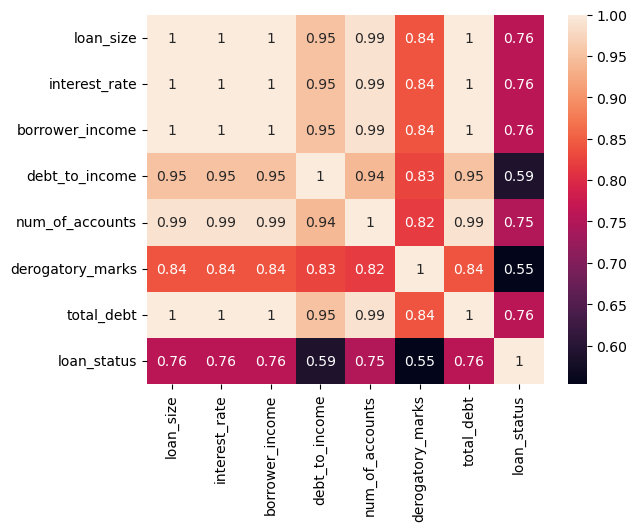

In [7]:
sns.heatmap(corrs, annot=True)
plt.show()

In [9]:
# A lot of features correlate to loan status.

In [10]:
abs(corrs.loan_status).sort_values(ascending=False)

loan_status         1.000000
interest_rate       0.758900
borrower_income     0.758890
total_debt          0.758890
loan_size           0.758846
num_of_accounts     0.749802
debt_to_income      0.589305
derogatory_marks    0.553187
Name: loan_status, dtype: float64

In [11]:
# Check for imbalance
df.loan_status.value_counts()
# 0 = healthy, 1 = risk of default

loan_status
0    75036
1     2500
Name: count, dtype: int64

In [12]:
perc_default = 2500 / len(df.loan_status)
perc_default

0.03224308708212959

In [13]:
# There is a lot of imbalance here, so models may not be accurate.
# Or, target accuracy of model >96%, since 3.2% of borrowers defaulted on their loans.

### Step 2: Create the labels set (`y`)  from the “loan_status” column, and then create the features (`X`) DataFrame from the remaining columns.

In [16]:
df.columns

Index(['loan_size', 'interest_rate', 'borrower_income', 'debt_to_income',
       'num_of_accounts', 'derogatory_marks', 'total_debt', 'loan_status'],
      dtype='object')

In [17]:
# Separate the data into labels and features
features = ['loan_size', 'interest_rate', 'borrower_income', 'debt_to_income',
       'num_of_accounts', 'derogatory_marks', 'total_debt']

# Separate the y variable, the labels
y = df.loan_status

# Separate the X variable, the features
X = df.loc[:, features]

In [18]:
# Review the y variable Series
y.shape

(77536,)

In [19]:
# Review the X variable DataFrame
X.shape

(77536, 7)

In [21]:
# Scaling
scaler = StandardScaler()
scaler.fit(X)
scaled_data = scaler.transform(X)
df_scaled = pd.DataFrame(scaled_data, columns=X.columns)
df_scaled.head()

,loan_size,interest_rate,borrower_income,debt_to_income,num_of_accounts,derogatory_marks,total_debt
0,0.427304,0.426837,0.427404,0.668571,0.616143,1.043996,0.427404
1,-0.671487,-0.674918,-0.671552,-0.802166,-0.434049,-0.673973,-0.671552
2,-0.384846,-0.370249,-0.372922,-0.344424,-0.434049,-0.673973,-0.372922
3,0.427304,0.417844,0.415459,0.655346,0.616143,1.043996,0.415459
4,0.475078,0.456068,0.451295,0.694873,0.616143,1.043996,0.451295


In [22]:
# Confirm that data is normalized
df_scaled.describe()

,loan_size,interest_rate,borrower_income,debt_to_income,num_of_accounts,derogatory_marks,total_debt
count,77536.000000,7.753600e+04,77536.000000,7.753600e+04,7.753600e+04,7.753600e+04,77536.000000
mean,0.000000,-1.407596e-15,0.000000,-1.196457e-15,-4.691987e-17,-5.864983e-17,0.000000
std,1.000006,1.000006e+00,1.000006,1.000006e+00,1.000006e+00,1.000006e+00,1.000006
min,-2.295787,-2.296073e+00,-2.296096,-4.628640e+00,-2.009337e+00,-6.739731e-01,-2.296096
25%,-0.528166,-5.253942e-01,-0.528210,-5.760741e-01,-4.340494e-01,-6.739731e-01,-0.528210
50%,-0.145978,-1.352827e-01,-0.134019,-1.249033e-02,9.104661e-02,-6.739731e-01,-0.134019
75%,0.283984,2.649469e-01,0.260172,4.787266e-01,9.104661e-02,1.043996e+00,0.260172
max,6.685636,6.680987e+00,6.686676,4.140328e+00,6.392198e+00,4.479933e+00,6.686676


### Step 3: Split the data into training and testing datasets by using `train_test_split`.

In [23]:
# Split the data using train_test_split
# Assign a random_state of 1 to the function

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1, stratify=y)

---

## Create a Logistic Regression Model with the Original Data

In [46]:
# Function for Classification
def classificationModeling(model, X_train, X_test, y_train, y_test):
    # Fit the model
    model.fit(X_train, y_train)
    
    # Evaluate the model
    train_preds = model.predict(X_train)
    test_preds = model.predict(X_test)

    train_proba = model.predict_proba(X_train)[:, 1]
    test_proba = model.predict_proba(X_test)[:, 1]

    # Generate metrics TRAIN
    train_cf = confusion_matrix(y_train, train_preds)
    train_cr = classification_report(y_train, train_preds)
    train_auc = roc_auc_score(y_train, train_proba)
    
    train_results = f"""TRAIN METRICS
    Train Confusion Matrix: 
    {train_cf}

    Train Classification Report:
    {train_cr}

    Train AUC: {train_auc}
    """
    
    print(train_results)

    # Generate metrics TEST
    test_cf = confusion_matrix(y_test, test_preds)
    test_cr = classification_report(y_test, test_preds)
    test_auc = roc_auc_score(y_test, test_proba)
    
    test_results = f"""TEST METRICS
    Test Confusion Matrix: 
    {test_cf}

    Test Classification Report:
    {test_cr}

    Test AUC: {test_auc}
    """
    
    print(test_results)

    # VISUALIZE TEST RESULTS
    # Confusion Matrix
    plt.figure(figsize=(4, 4))
    sns.heatmap(test_cf, annot=True, fmt='d', cmap='Blues', cbar=False, 
                xticklabels=['Predicted Negative', 'Predicted Positive'], 
                yticklabels=['Actual Negative', 'Actual Positive'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    # # Plot the ROC curve
    fpr, tpr, _ = roc_curve(y_test.values, test_proba)
    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {test_auc:.2f})')
    
    # Plot the diagonal reference line
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    
    # Titles and labels
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
    # Add grid and legend
    plt.grid(linestyle="--", color="lightgrey", alpha=0.75)
    plt.legend(loc="lower right")
    
    # Display the plot
    plt.show()

TRAIN METRICS
    Train Confusion Matrix: 
    [[55967   310]
 [  116  1759]]

    Train Classification Report:
                  precision    recall  f1-score   support

           0       1.00      0.99      1.00     56277
           1       0.85      0.94      0.89      1875

    accuracy                           0.99     58152
   macro avg       0.92      0.97      0.94     58152
weighted avg       0.99      0.99      0.99     58152


    Train AUC: 0.9944504741427818
    
TEST METRICS
    Test Confusion Matrix: 
    [[18673    86]
 [   32   593]]

    Test Classification Report:
                  precision    recall  f1-score   support

           0       1.00      1.00      1.00     18759
           1       0.87      0.95      0.91       625

    accuracy                           0.99     19384
   macro avg       0.94      0.97      0.95     19384
weighted avg       0.99      0.99      0.99     19384


    Test AUC: 0.9963734527426835
    


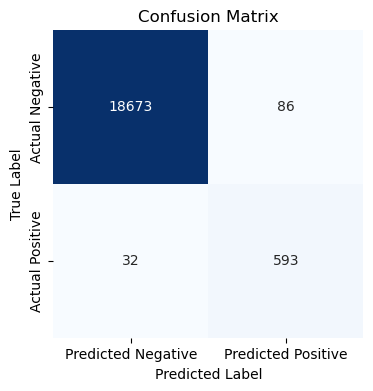

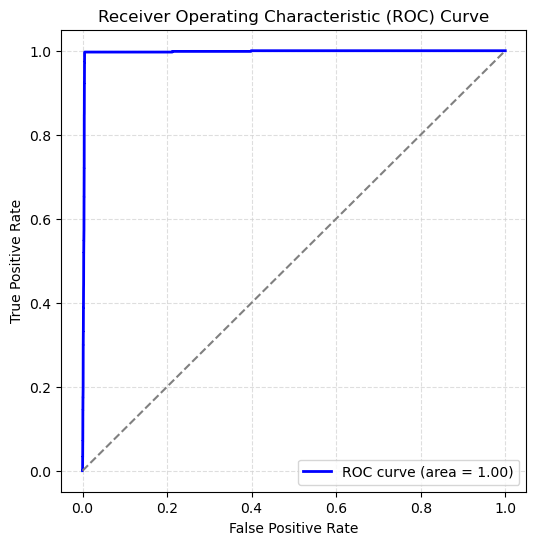

In [47]:
# Initiate the model
lr = LogisticRegression()

# Do Machine Learning
classificationModeling(lr, X_train, X_test, y_train, y_test)

###  Fit a decision tree model.

TRAIN METRICS
    Train Confusion Matrix: 
    [[56224    53]
 [  102  1773]]
    
    Train AUC: 0.9998578886578886

    Train Classification Report:
                  precision    recall  f1-score   support

           0       1.00      1.00      1.00     56277
           1       0.97      0.95      0.96      1875

    accuracy                           1.00     58152
   macro avg       0.98      0.97      0.98     58152
weighted avg       1.00      1.00      1.00     58152

    
TEST METRICS
    Test Confusion Matrix: 
    [[18685    74]
 [  122   503]]
    
    Test AUC: 0.9399174796097873

    Test Classification Report:
                  precision    recall  f1-score   support

           0       0.99      1.00      0.99     18759
           1       0.87      0.80      0.84       625

    accuracy                           0.99     19384
   macro avg       0.93      0.90      0.92     19384
weighted avg       0.99      0.99      0.99     19384

    


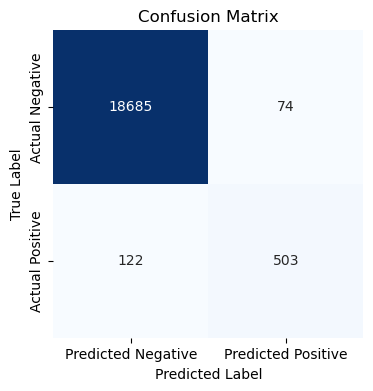

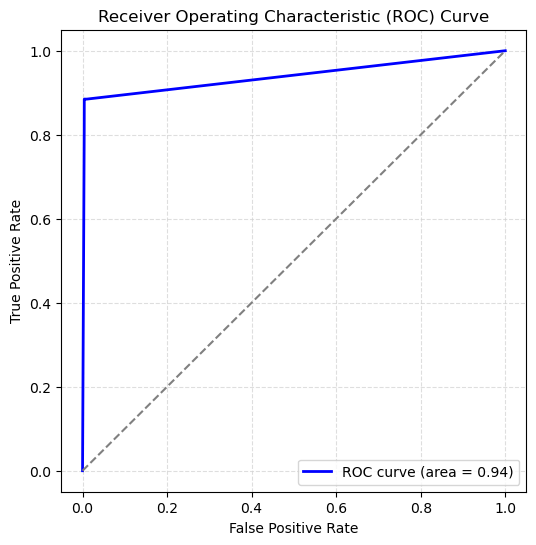

In [26]:
# Initiate the model
dt = DecisionTreeClassifier()

# Do Machine Learning
classificationModeling(dt, X_train, X_test, y_train, y_test)

### Fit a RandomForest model.

TRAIN METRICS
    Train Confusion Matrix: 
    [[56147   130]
 [   25  1850]]
    
    Train AUC: 0.9998245582860967

    Train Classification Report:
                  precision    recall  f1-score   support

           0       1.00      1.00      1.00     56277
           1       0.93      0.99      0.96      1875

    accuracy                           1.00     58152
   macro avg       0.97      0.99      0.98     58152
weighted avg       1.00      1.00      1.00     58152

    
TEST METRICS
    Test Confusion Matrix: 
    [[18681    78]
 [   82   543]]
    
    Test AUC: 0.9958642998027613

    Test Classification Report:
                  precision    recall  f1-score   support

           0       1.00      1.00      1.00     18759
           1       0.87      0.87      0.87       625

    accuracy                           0.99     19384
   macro avg       0.94      0.93      0.93     19384
weighted avg       0.99      0.99      0.99     19384

    


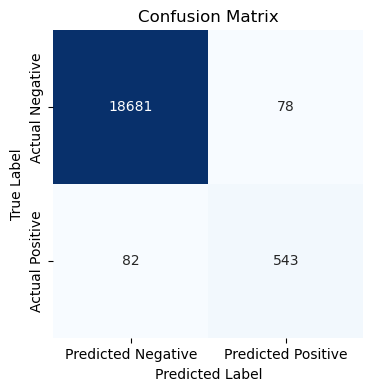

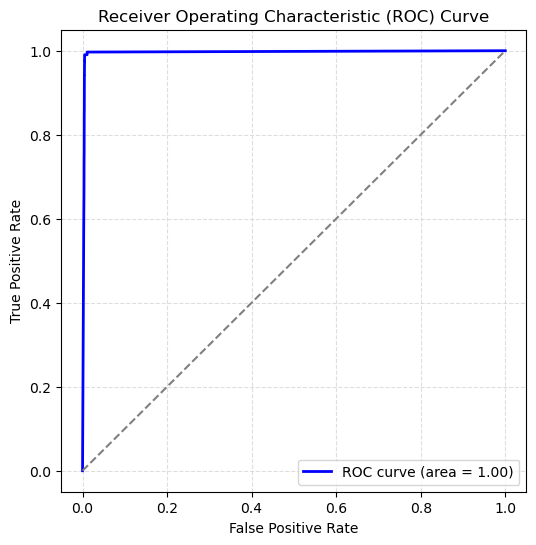

In [29]:
# Initiate the model
rf = RandomForestClassifier()

# Do Machine Learning
classificationModeling(rf, X_train, X_test, y_train, y_test)

### Fit a Support Vector Machine model.

TRAIN METRICS
    Train Confusion Matrix: 
    [[55952   325]
 [   15  1860]]
    
    Train AUC: 0.9940249361787823

    Train Classification Report:
                  precision    recall  f1-score   support

           0       1.00      0.99      1.00     56277
           1       0.85      0.99      0.92      1875

    accuracy                           0.99     58152
   macro avg       0.93      0.99      0.96     58152
weighted avg       0.99      0.99      0.99     58152

    
TEST METRICS
    Test Confusion Matrix: 
    [[18669    90]
 [    5   620]]
    
    Test AUC: 0.9968010235087158

    Test Classification Report:
                  precision    recall  f1-score   support

           0       1.00      1.00      1.00     18759
           1       0.87      0.99      0.93       625

    accuracy                           1.00     19384
   macro avg       0.94      0.99      0.96     19384
weighted avg       1.00      1.00      1.00     19384

    


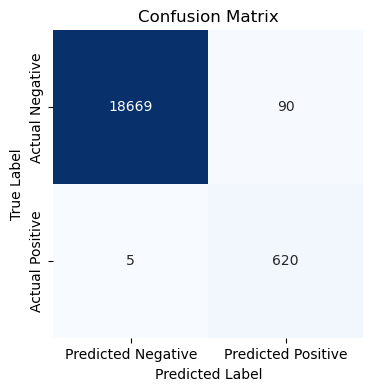

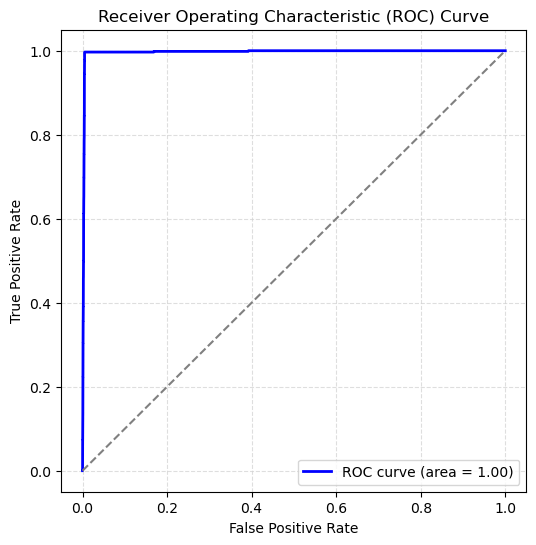

In [31]:
# Initiate the model
svc = SVC(probability=True)

# Do Machine Learning
classificationModeling(svc, X_train, X_test, y_train, y_test)

### Fit a K-Nearest Neighbors model.

TRAIN METRICS
    Train Confusion Matrix: 
    [[55951   326]
 [   14  1861]]
    
    Train AUC: 0.9970335353104584

    Train Classification Report:
                  precision    recall  f1-score   support

           0       1.00      0.99      1.00     56277
           1       0.85      0.99      0.92      1875

    accuracy                           0.99     58152
   macro avg       0.93      0.99      0.96     58152
weighted avg       0.99      0.99      0.99     58152

    
TEST METRICS
    Test Confusion Matrix: 
    [[18669    90]
 [    5   620]]
    
    Test AUC: 0.9958778186470494

    Test Classification Report:
                  precision    recall  f1-score   support

           0       1.00      1.00      1.00     18759
           1       0.87      0.99      0.93       625

    accuracy                           1.00     19384
   macro avg       0.94      0.99      0.96     19384
weighted avg       1.00      1.00      1.00     19384

    


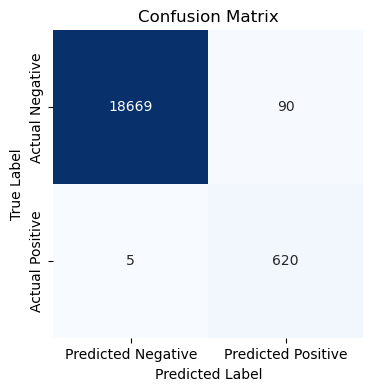

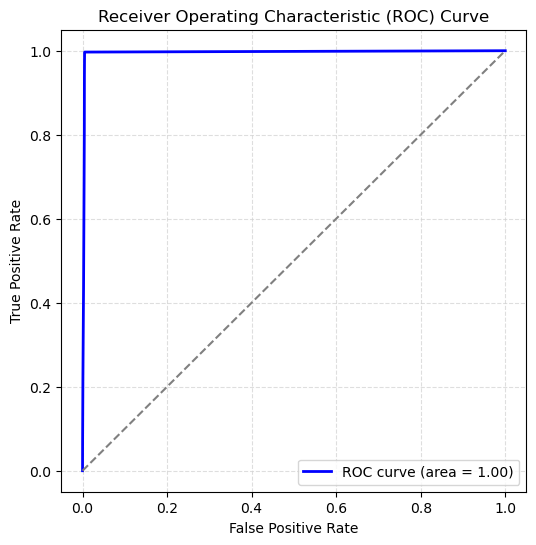

In [32]:
# Initiate the model
knn = KNeighborsClassifier(n_neighbors=25)

# Do Machine Learning
classificationModeling(knn, X_train, X_test, y_train, y_test)

### Fit an ExtraTrees Classifier model.

TRAIN METRICS
    Train Confusion Matrix: 
    [[56224    53]
 [  102  1773]]
    
    Train AUC: 0.9998578886578886

    Train Classification Report:
                  precision    recall  f1-score   support

           0       1.00      1.00      1.00     56277
           1       0.97      0.95      0.96      1875

    accuracy                           1.00     58152
   macro avg       0.98      0.97      0.98     58152
weighted avg       1.00      1.00      1.00     58152

    
TEST METRICS
    Test Confusion Matrix: 
    [[18682    77]
 [  107   518]]
    
    Test AUC: 0.9614341062956447

    Test Classification Report:
                  precision    recall  f1-score   support

           0       0.99      1.00      1.00     18759
           1       0.87      0.83      0.85       625

    accuracy                           0.99     19384
   macro avg       0.93      0.91      0.92     19384
weighted avg       0.99      0.99      0.99     19384

    


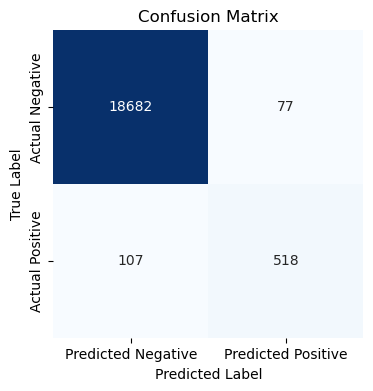

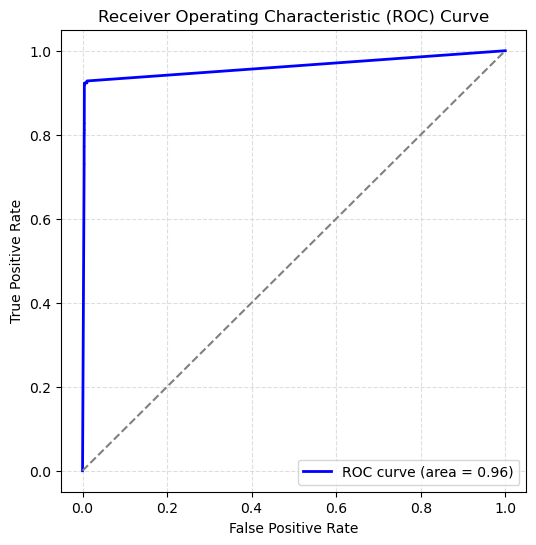

In [33]:
# Initiate the model
et = ExtraTreesClassifier()

# Do Machine Learning
classificationModeling(et, X_train, X_test, y_train, y_test)

### Fit an AdaBoost Classifier model.

TRAIN METRICS
    Train Confusion Matrix: 
    [[55954   323]
 [   15  1860]]
    
    Train AUC: 0.9970676854369163

    Train Classification Report:
                  precision    recall  f1-score   support

           0       1.00      0.99      1.00     56277
           1       0.85      0.99      0.92      1875

    accuracy                           0.99     58152
   macro avg       0.93      0.99      0.96     58152
weighted avg       0.99      0.99      0.99     58152

    
TEST METRICS
    Test Confusion Matrix: 
    [[18669    90]
 [    5   620]]
    
    Test AUC: 0.9964305986459833

    Test Classification Report:
                  precision    recall  f1-score   support

           0       1.00      1.00      1.00     18759
           1       0.87      0.99      0.93       625

    accuracy                           1.00     19384
   macro avg       0.94      0.99      0.96     19384
weighted avg       1.00      1.00      1.00     19384

    


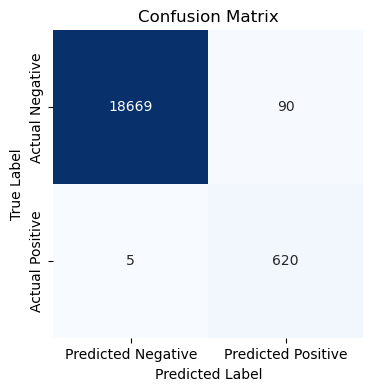

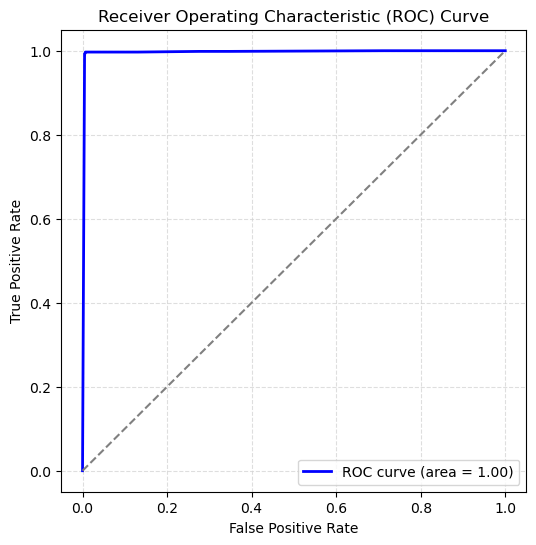

In [34]:
# Initiate the model
ada = AdaBoostClassifier()

# Do Machine Learning
classificationModeling(ada, X_train, X_test, y_train, y_test)

### Fit a Gradient Boosting Classifier model.

TRAIN METRICS
    Train Confusion Matrix: 
    [[55965   312]
 [   10  1865]]
    
    Train AUC: 0.9983701855701855

    Train Classification Report:
                  precision    recall  f1-score   support

           0       1.00      0.99      1.00     56277
           1       0.86      0.99      0.92      1875

    accuracy                           0.99     58152
   macro avg       0.93      0.99      0.96     58152
weighted avg       1.00      0.99      0.99     58152

    
TEST METRICS
    Test Confusion Matrix: 
    [[18668    91]
 [    6   619]]
    
    Test AUC: 0.9952677648062264

    Test Classification Report:
                  precision    recall  f1-score   support

           0       1.00      1.00      1.00     18759
           1       0.87      0.99      0.93       625

    accuracy                           0.99     19384
   macro avg       0.94      0.99      0.96     19384
weighted avg       1.00      0.99      1.00     19384

    


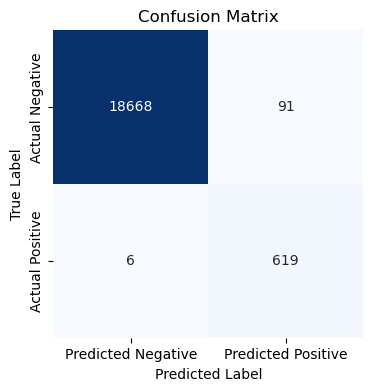

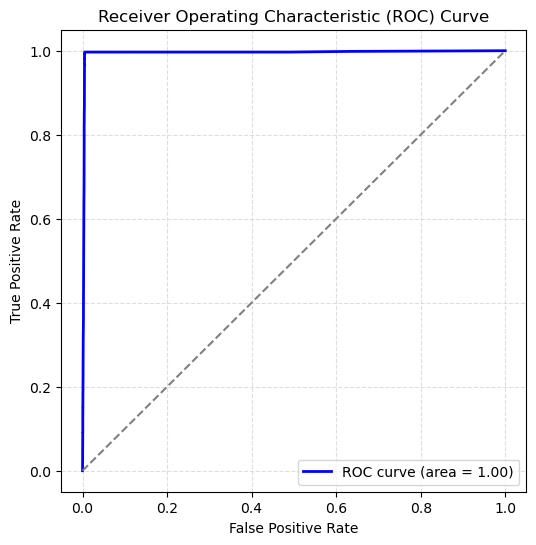

In [36]:
# Initiate the model
gb = GradientBoostingClassifier(random_state=1)

# Do Machine Learning
classificationModeling(gb, X_train, X_test, y_train, y_test)

### Fit an Extra Gradient Boost Classifier model.

TRAIN METRICS
    Train Confusion Matrix: 
    [[55954   323]
 [   13  1862]]
    
    Train AUC: 0.997842699504238

    Train Classification Report:
                  precision    recall  f1-score   support

           0       1.00      0.99      1.00     56277
           1       0.85      0.99      0.92      1875

    accuracy                           0.99     58152
   macro avg       0.93      0.99      0.96     58152
weighted avg       1.00      0.99      0.99     58152

    
TEST METRICS
    Test Confusion Matrix: 
    [[18669    90]
 [    4   621]]
    
    Test AUC: 0.9956511114664961

    Test Classification Report:
                  precision    recall  f1-score   support

           0       1.00      1.00      1.00     18759
           1       0.87      0.99      0.93       625

    accuracy                           1.00     19384
   macro avg       0.94      0.99      0.96     19384
weighted avg       1.00      1.00      1.00     19384

    


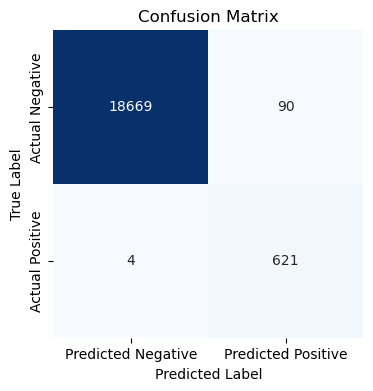

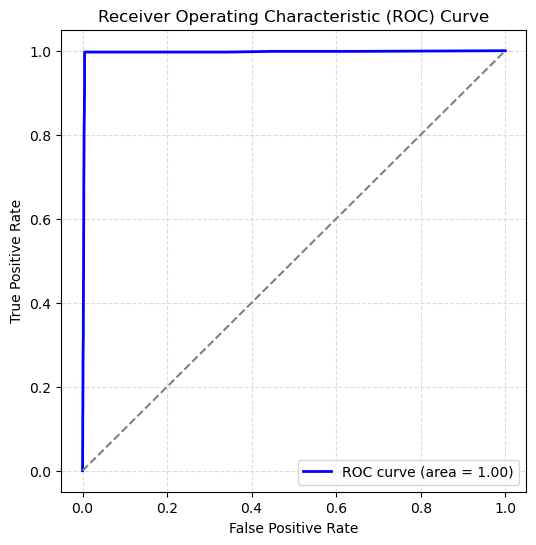

In [42]:
# Initiate the model
xgb = XGBClassifier(random_state=1)

# Do Machine Learning
classificationModeling(xgb, X_train, X_test, y_train, y_test)

### Fit a Light Gradient Boost Classifier model.

TRAIN METRICS
    Train Confusion Matrix: 
    [[55954   323]
 [   15  1860]]
    
    Train AUC: 0.9970676854369163

    Train Classification Report:
                  precision    recall  f1-score   support

           0       1.00      0.99      1.00     56277
           1       0.85      0.99      0.92      1875

    accuracy                           0.99     58152
   macro avg       0.93      0.99      0.96     58152
weighted avg       0.99      0.99      0.99     58152

    
TEST METRICS
    Test Confusion Matrix: 
    [[18669    90]
 [    5   620]]
    
    Test AUC: 0.9964305986459833

    Test Classification Report:
                  precision    recall  f1-score   support

           0       1.00      1.00      1.00     18759
           1       0.87      0.99      0.93       625

    accuracy                           1.00     19384
   macro avg       0.94      0.99      0.96     19384
weighted avg       1.00      1.00      1.00     19384

    


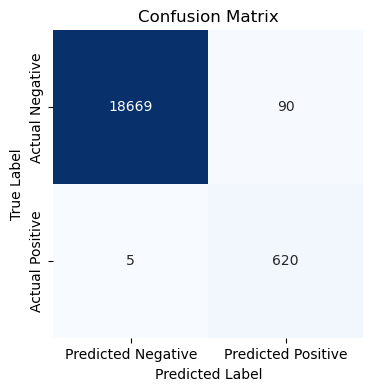

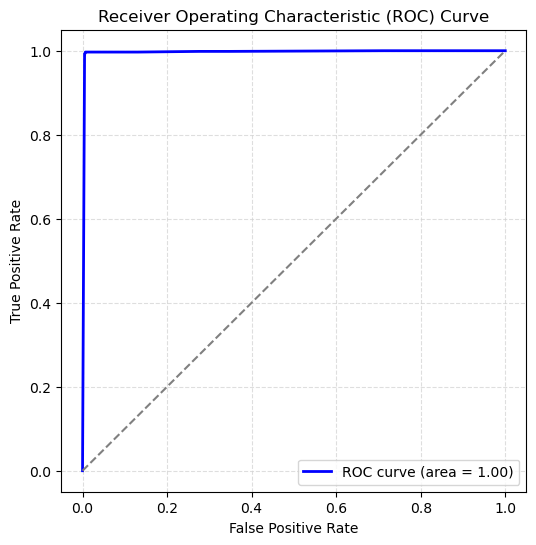

In [43]:
# Initiate the model
lgbm = LGBMClassifier(random_state=1, verbose=-1)

# Do Machine Learning
classificationModeling(ada, X_train, X_test, y_train, y_test)

### Step 4: Answer the following question.

**Question:** How well does the logistic regression model predict both the `0` (healthy loan) and `1` (high-risk loan) labels?

**Answer:** The model is perfect for predicting those with healthy loans (true negatives). It has an 87% precision (13% false positive) rate and a 95% recall (5% false negative) rate for predicting those who will default on their loans, meaning that the model is more likely to say a lender will default on their loans when they won't than it is to say that a lender won't default on their loans when they will. Because the data is imbalanced with almost 97% healthy loans, the model shows 99% overall accuracy. The area under the curve (AUC) of 99.637% reflects this, indicating a near perfect model, though this is misleading since our data is imbalanced and we know there is still a 9% chance (based on f1 score for loan_status=1) the model will incorrectly label a loan recipient who will default.

**Additional Models:** The AdaBoost model is the highest performing model here, with a test AUC of 99.643% and perfect scores for predicting healthy loans. It has an 87% precision rate and a 99% recall rate for predicting default loans, indicating the same conclusions as the logistic model but with higher accuracy, since the chance it will incorrectly label a defaulting loan recipient is 7%.

---